In [0]:
import warnings                                  # do not disturbe mode
warnings.filterwarnings('ignore')

# Load packages
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions

# Importing everything from forecasting quality metrics
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error


In [0]:
! pip install tqdm
! pip install pmdarima

     |████████████████████████████████| 78 kB 4.8 MB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-aeb505ca-a6bc-4941-826d-747e5f022fe0/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 1.9 MB 14.0 MB/s 
     |██▊                             | 1.5 MB 43.0 MB/

*** WARNING: max output size exceeded, skipping output. ***

     |████████████████████████████████| 16.8 MB 56.2 MB/s 
     |████████████████████████████████| 40 kB 6.4 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Not uninstalling numpy at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-aeb505ca-a6bc-4941-826d-747e5f022fe0
    Can't uninstall 'numpy'. No files were found to uninstall.
  Attempting uninstall: packaging
    Found existing installation: packaging 21.0
    Not uninstalling packaging at /databricks/python3/lib/python3.9/site-packages, o

In [0]:
df = pd.read_csv("/dbfs/FileStore/shared_uploads/chien.liu@hellofresh.com/within_covid.csv", parse_dates=['ds'])
df_covid = pd.read_csv("/dbfs/FileStore/shared_uploads/chien.liu@hellofresh.com/Covid.csv")

In [0]:
df_input = df.copy()
df_input['ds'] = pd.to_datetime(df_input['ds'])
df_activations = df_input[['ds', 'simulated']]
df_activations = df_activations.rename(columns = {'simulated':'activations'})
df_activations_index = df_activations.set_index(['ds'])
df_activations.head()

,ds,activations
0,2018-01-07 00:00:00+00:00,4893.0
1,2018-01-14 00:00:00+00:00,4695.0
2,2018-01-21 00:00:00+00:00,4510.0
3,2018-01-28 00:00:00+00:00,4760.0
4,2018-02-04 00:00:00+00:00,4467.0


In [0]:
def test_ts(ts, w, title='test_ts'):
    roll_mean = ts.rolling(window = w).mean()
    roll_std = ts.rolling(window = w).std()
    pd_ewma = ts.ewm(com = 0.5).mean()
    
    plt.figure(figsize = (20, 8))
    plt.clf()
    plt.grid()
    plt.plot(ts, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.plot(pd_ewma, color='yellow', label = 'EWMA')
    plt.legend(loc='best')
    plt.title('Revenue Rolling Mean & Standard Deviation')
    plt.show()

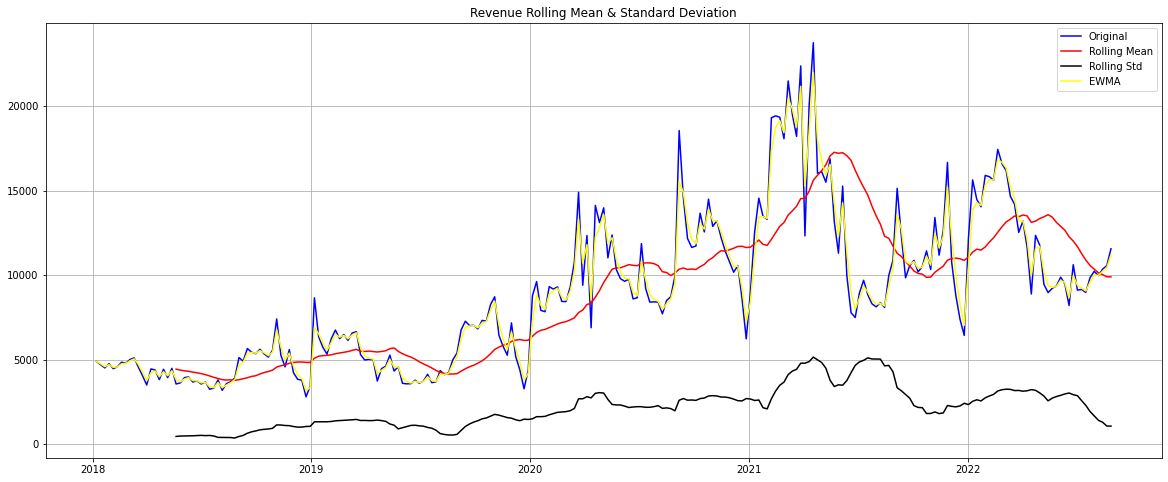

In [0]:
test_ts(df_activations_index, 20, title='test_org')

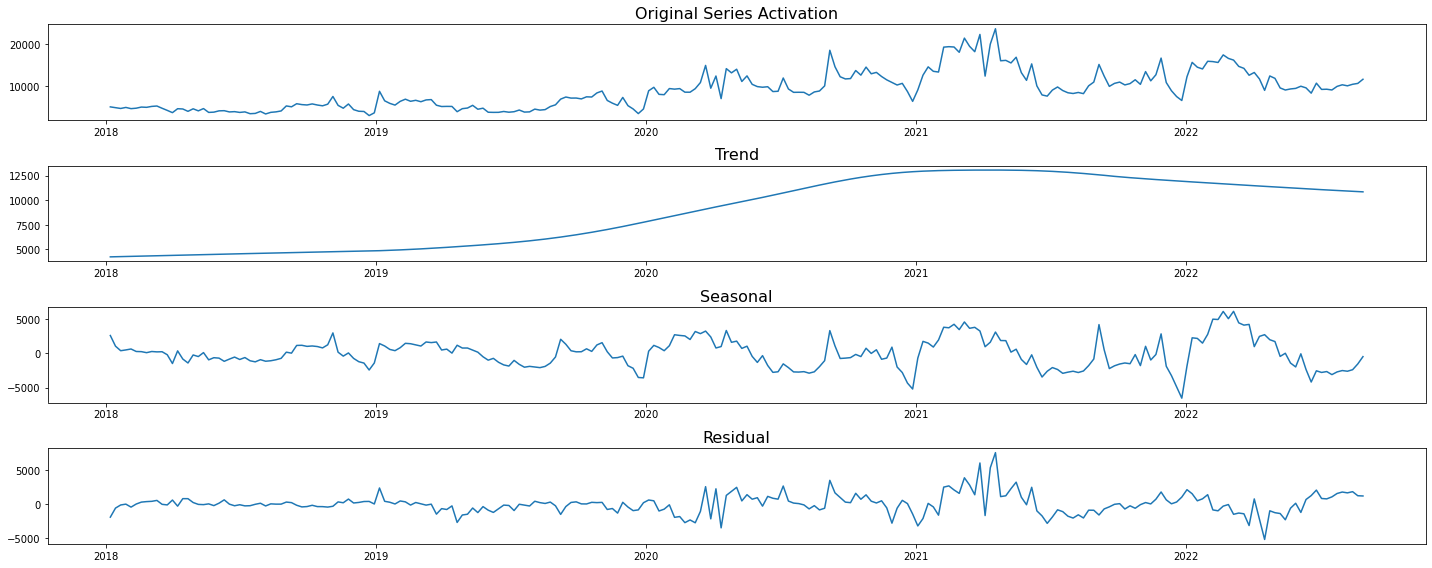

In [0]:
from statsmodels.tsa.seasonal import STL

stl_cost = STL(df_activations_index)
result_cost = stl_cost.fit()

seasonal_cost, trend_cost, resid_cost = result_cost.seasonal, result_cost.trend, result_cost.resid

plt.figure(figsize=(20,8))


plt.subplot(4,1,1)
plt.plot(df_activations_index)
plt.title('Original Series Activation', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend_cost)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal_cost)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid_cost)
plt.title('Residual', fontsize=16)

plt.tight_layout()

In [0]:
import pmdarima as pm
from pmdarima import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np

train, test = model_selection.train_test_split(df_activations_index, train_size=int(len(df_activations_index)*0.8))

# Fit a simple auto_arima model
modl = pm.auto_arima(train, seasonal=True, stepwise=True, m=52, d=1, D=0)

# Create predictions for the future, evaluate on test
preds, conf_int = modl.predict(n_periods=test.shape[0], return_conf_int=True)

# cv = model_selection.SlidingWindowForecastCV(window_size=150, step=4, h=4)
# predictions = model_selection.cross_val_predict(
#     modl, cost, cv=cv, verbose=2, averaging="median")

# # plot the predictions over the original series
# x_axis = np.arange(cost.shape[0])
# n_test = predictions.shape[0]

# plt.plot(x_axis, cost, alpha=0.75, c='b')
# plt.plot(x_axis[-n_test:], predictions, alpha=0.75, c='g')  # Forecasts
# plt.title("Cross-validated wineind forecasts")
# plt.show()

# Print the error:
print("Test R2:" + str((r2_score(test, preds))))
print("Test MAPE:" + str((mean_absolute_percentage_error(test, preds))))

In [0]:
preds

Out[27]: 2021-09-26 00:00:00+00:00    11049.394661
2021-10-03 00:00:00+00:00    11049.394661
2021-10-10 00:00:00+00:00    11049.394661
2021-10-17 00:00:00+00:00    11049.394661
2021-10-24 00:00:00+00:00    11049.394661
2021-10-31 00:00:00+00:00    11049.394661
2021-11-07 00:00:00+00:00    11049.394661
2021-11-14 00:00:00+00:00    11049.394661
2021-11-21 00:00:00+00:00    11049.394661
2021-11-28 00:00:00+00:00    11049.394661
2021-12-05 00:00:00+00:00    11049.394661
2021-12-12 00:00:00+00:00    11049.394661
2021-12-19 00:00:00+00:00    11049.394661
2021-12-26 00:00:00+00:00    11049.394661
2022-01-02 00:00:00+00:00    11049.394661
2022-01-09 00:00:00+00:00    11049.394661
2022-01-16 00:00:00+00:00    11049.394661
2022-01-23 00:00:00+00:00    11049.394661
2022-01-30 00:00:00+00:00    11049.394661
2022-02-06 00:00:00+00:00    11049.394661
2022-02-13 00:00:00+00:00    11049.394661
2022-02-20 00:00:00+00:00    11049.394661
2022-02-27 00:00:00+00:00    11049.394661
2022-03-06 00:00:00+00:00

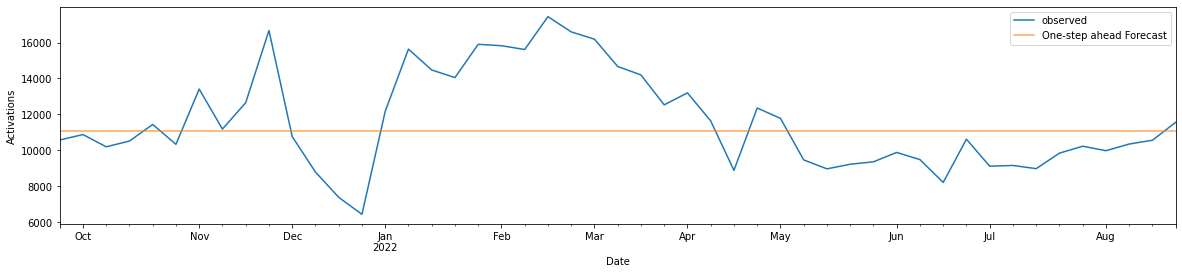

In [0]:
plt.figure(figsize = (20, 4))

ax = test['activations'].plot(label='observed')
preds.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Activations')
plt.legend()


plt.show()